* MSV_HoVaTen:
521H0501_Phan Minh Hoàng,
521H0398_Lê Nguyễn Viết Hiệp,
521H0276_Trang Sĩ Nam



In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [127]:
data = pd.read_csv('bike_buyers.csv')
print(data.shape)

(1000, 13)


In [128]:
data = data.dropna()

In [129]:
data.duplicated().value_counts()

False    952
dtype: int64

In [130]:
data = data.drop_duplicates()
data.shape

(952, 13)

# Transformation

In [131]:
# Tranform data
from sklearn.preprocessing import LabelEncoder

types = data.dtypes
names = list(data.columns)

le = LabelEncoder()
for i in range(len(types)):
    if types.iloc[i]=='object':
        le.fit_transform(data[names[i]])
        data[names[i]] = le.transform(data[names[i]])

# Normalization


In [132]:
from sklearn.preprocessing import MinMaxScaler
features = data.drop(['Purchased Bike'], axis=1)

scaler = MinMaxScaler()
model=scaler.fit(features)
scaled_data= pd.DataFrame(model.transform(features))

In [133]:
# split data
X = scaled_data
y = data['Purchased Bike']

- Sử dụng FeatureSelection để chọn ra các features ảnh hưởng nhất đến độ chính xác của mô hình - một phương thức tránh Overfitting

# Feature Selection

In [134]:
from sklearn.feature_selection import SelectKBest, chi2
select_feature =  SelectKBest(score_func=chi2, k = 8)
f_best = select_feature.fit(X, y)
X_new = f_best.transform(X)
X_new.shape

(952, 8)

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, random_state = 42, test_size=0.2)

# K Nearest Neighbor (Cross-Validation)

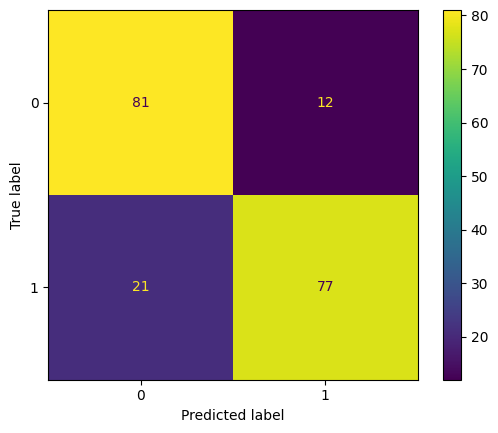

In [136]:
# Train model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

KNN = KNeighborsClassifier(n_neighbors = 5, p=2, metric='euclidean')

scores = cross_val_score(KNN, X_new, data["Purchased Bike"], cv=5)

# Train and evaluate model
KNN.fit(X_new, data["Purchased Bike"])
Y_pred = KNN.predict(X_new)

# test model
Y_pred = KNN.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [137]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        93
           1       0.87      0.79      0.82        98

    accuracy                           0.83       191
   macro avg       0.83      0.83      0.83       191
weighted avg       0.83      0.83      0.83       191



# Decision Tree (GridSearchCV + Cross-Validation)


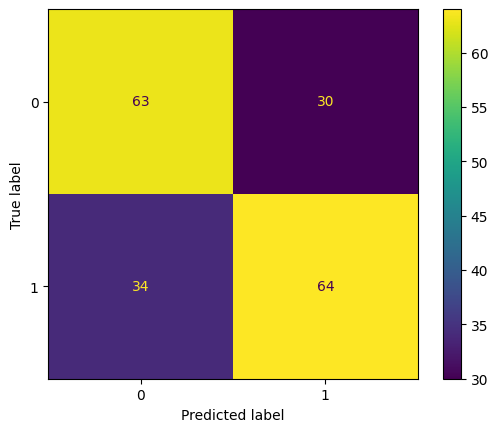

In [138]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

dTree = DecisionTreeClassifier(max_depth=7)
param_grid = {
    "max_depth": [3, 5, 7, 9],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}
grid_search = GridSearchCV(dTree, param_grid, cv=5)

# Tìm kiếm siêu tham số tối ưu và huấn luyện mô hình
grid_search.fit(X_new, data["Purchased Bike"])
best_dt = grid_search.best_estimator_
Y_pred = best_dt.predict(X_new)

dTree.fit(X_train, Y_train)

Y_pred = dTree.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [139]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66        93
           1       0.68      0.65      0.67        98

    accuracy                           0.66       191
   macro avg       0.67      0.67      0.66       191
weighted avg       0.67      0.66      0.66       191



# Random Forest (Cross-Validation)

Cross-validation scores: [0.58974359 0.65789474 0.68421053 0.65789474 0.60526316]


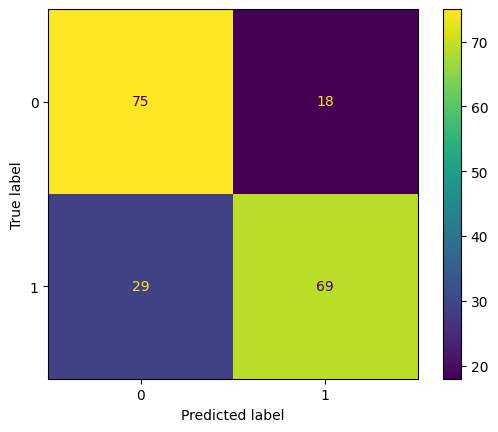

In [140]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train, Y_train)

# Evaluate model
scores = cross_val_score(rf, X_test, Y_test, cv=5)
print("Cross-validation scores:", scores)

# Test model
Y_pred = rf.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [141]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76        93
           1       0.79      0.70      0.75        98

    accuracy                           0.75       191
   macro avg       0.76      0.76      0.75       191
weighted avg       0.76      0.75      0.75       191



# Multinomial Naive Bayes

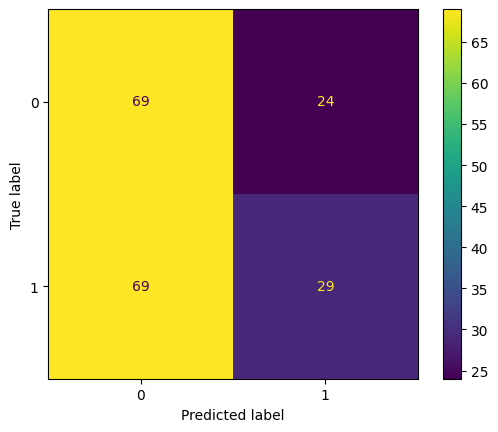

In [142]:
from sklearn.naive_bayes import MultinomialNB

class EarlyStoppingNB(MultinomialNB):
    def fit(self, X, y, callbacks=None, **kwargs):
        self.callbacks = callbacks
        super().fit(X, y, **kwargs)

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_train_end()

mnb = EarlyStoppingNB()
es = EarlyStopping(patience=10)
mnb.fit(X_train, Y_train, callbacks=[es])

# test model
Y_pred = mnb.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [143]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.50      0.74      0.60        93
           1       0.55      0.30      0.38        98

    accuracy                           0.51       191
   macro avg       0.52      0.52      0.49       191
weighted avg       0.52      0.51      0.49       191



# Bernoulli Naive Bayes

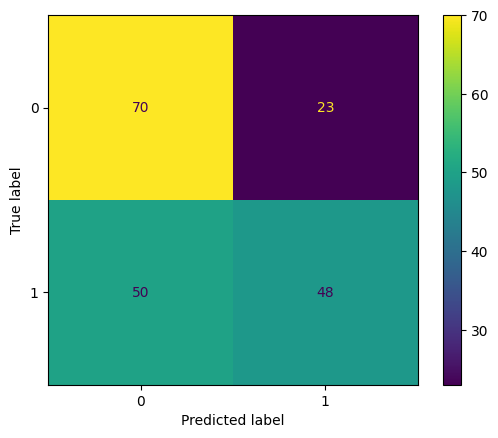

In [144]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

bnb = BernoulliNB()
scores = cross_val_score(bnb, X_new, data["Purchased Bike"], cv=5)
# Sau khi đánh giá bằng cross-validation, có thể huấn luyện mô hình trên toàn bộ dữ liệu huấn luyện
bnb.fit(X_new, data["Purchased Bike"])
# test model
Y_pred = bnb.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [145]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.58      0.75      0.66        93
           1       0.68      0.49      0.57        98

    accuracy                           0.62       191
   macro avg       0.63      0.62      0.61       191
weighted avg       0.63      0.62      0.61       191



# Logistic Regession

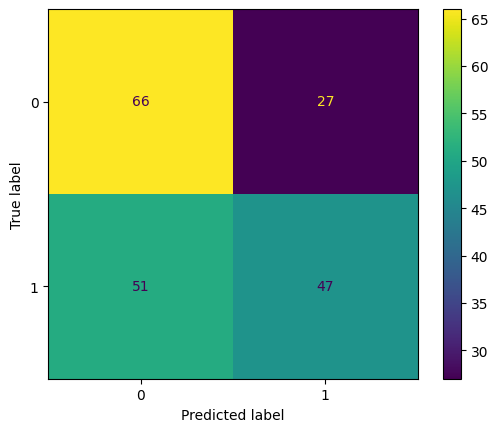

In [146]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [147]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.56      0.71      0.63        93
           1       0.64      0.48      0.55        98

    accuracy                           0.59       191
   macro avg       0.60      0.59      0.59       191
weighted avg       0.60      0.59      0.59       191



# Support Vector Machine (Lựa chọn Kernel + Chuẩn hóa dữ liệu)

Chuẩn hóa dữ liệu: Accuracy: 0.4869109947643979


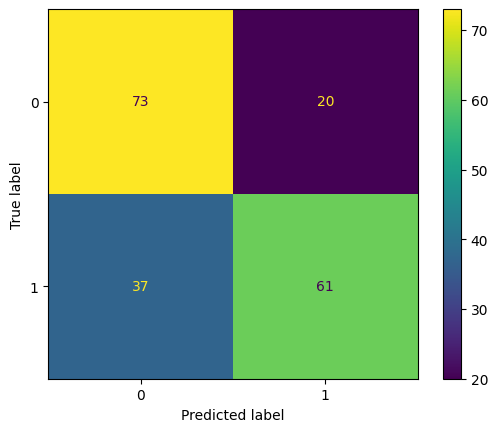

In [160]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

kernels = ["linear", "poly", "rbf", "sigmoid",]

for kernel in kernels:
    svm = SVC(kernel=kernel, C=2.5)
    svm.fit(X_train, Y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel="sigmoid", C=2.5)
svm.fit(X_train_scaled, Y_train)

y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, y_pred)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print("Chuẩn hóa dữ liệu:", "Accuracy:", accuracy)

In [161]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.66      0.78      0.72        93
           1       0.75      0.62      0.68        98

    accuracy                           0.70       191
   macro avg       0.71      0.70      0.70       191
weighted avg       0.71      0.70      0.70       191



# Ensamble

* Bagging (Tăng số lượng estimator)

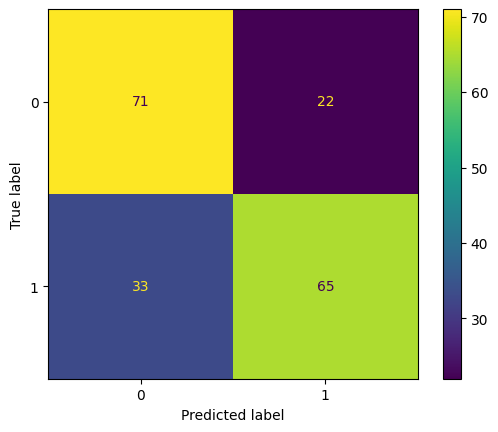

In [168]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(estimator=DecisionTreeClassifier(),
                        n_estimators=100, random_state=0).fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [169]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72        93
           1       0.75      0.66      0.70        98

    accuracy                           0.71       191
   macro avg       0.71      0.71      0.71       191
weighted avg       0.72      0.71      0.71       191



* GradientBoosting (GradientBoostingClassifer + subsample + GridSearchCV)

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}


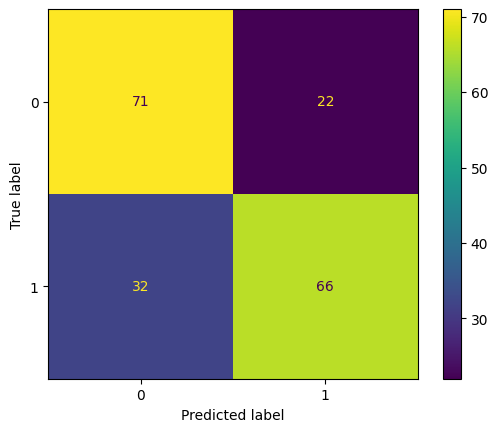

In [189]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Tạo grid các siêu tham số để thử nghiệm
param_grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4],
    "n_estimators": [100, 200],
    "subsample": [0.7, 0.8]
}

# Tìm cấu hình tốt nhất bằng GridSearchCV
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=0), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Huấn luyện mô hình với các siêu tham số tốt nhất
clf = GradientBoostingClassifier(**best_params, random_state=0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [188]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.69      0.76      0.72        93
           1       0.75      0.67      0.71        98

    accuracy                           0.72       191
   macro avg       0.72      0.72      0.72       191
weighted avg       0.72      0.72      0.72       191



* Stack

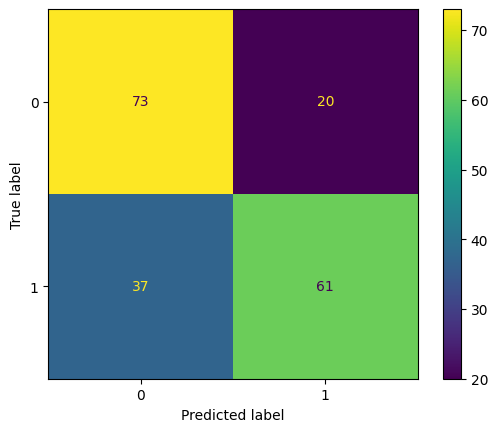

In [155]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

layer = list()

layer.append(('dt', DecisionTreeClassifier()))
layer.append(('bnb', BernoulliNB()))
layer.append(('svc', SVC()))

finalLayer = LogisticRegression()

model = StackingClassifier(estimators=layer, final_estimator=finalLayer, cv=5)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [156]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.66      0.78      0.72        93
           1       0.75      0.62      0.68        98

    accuracy                           0.70       191
   macro avg       0.71      0.70      0.70       191
weighted avg       0.71      0.70      0.70       191

